# Nearest-neighbor graph mappings

In [1]:
import os

import xarray as xr
import numpy as np

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cf

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from sklearn.neighbors import NearestNeighbors

In [4]:
import dask
from dask.distributed import Client, LocalCluster

In [5]:
import torch
from torch_geometric.data import HeteroData 

/perm/pamc/conda/envs/gnn-pyg-2.1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import h3

In [7]:
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)

In [8]:
NUM_ERA_NEIGHBORS = 9
NUM_H3_NEIGHBORS = 7

## ERA5 -> H3

In [9]:
with client:
    era = xr.open_dataset("/ec/res4/hpcperm/syma/WeatherBench/netcdf/pl_2004.nc", chunks={"time": 5})
era

,Array,Chunk
Bytes,4.62 GiB,16.16 MiB
Shape,"(1464, 13, 181, 360)","(5, 13, 181, 360)"
Count,2 Graph Layers,293 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,4.62 GiB,16.16 MiB
Shape,"(1464, 13, 181, 360)","(5, 13, 181, 360)"
Count,2 Graph Layers,293 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [10]:
era = era.assign_coords({"longitude": (((era.longitude + 180) % 360) - 180)})
era = era.sortby("longitude").sortby("latitude")
era

,Array,Chunk
Bytes,4.62 GiB,16.16 MiB
Shape,"(1464, 13, 181, 360)","(5, 13, 181, 360)"
Count,4 Graph Layers,293 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,4.62 GiB,16.16 MiB
Shape,"(1464, 13, 181, 360)","(5, 13, 181, 360)"
Count,4 Graph Layers,293 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [11]:
era.longitude.min(), era.longitude.max()

(<xarray.DataArray 'longitude' ()>
 array(-180., dtype=float32),
 <xarray.DataArray 'longitude' ()>
 array(179., dtype=float32))

In [12]:
era.latitude.min(), era.latitude.max()

(<xarray.DataArray 'latitude' ()>
 array(-90., dtype=float32),
 <xarray.DataArray 'latitude' ()>
 array(90., dtype=float32))

In [13]:
elats, elons = np.meshgrid(era.latitude.values, era.longitude.values)
ecoords = np.array([elats, elons]).T.reshape((-1, 2))
ecoords.shape

(65160, 2)

In [14]:
elats = np.array(era["latitude"])
elons = np.array(era["longitude"])
ecoords_v2 = np.stack(np.meshgrid(elats, elons, indexing="ij"), axis=-1).reshape((-1,2))
ecoords_v2.shape

(65160, 2)

In [15]:
np.max(ecoords - ecoords_v2)

0.0

In [16]:
# convert to rad
ecoords_sp = np.deg2rad(ecoords)

eneigh = NearestNeighbors(
    n_neighbors=NUM_ERA_NEIGHBORS,
    metric="haversine",
    n_jobs=4
)
eneigh.fit(ecoords_sp)

NearestNeighbors(metric='haversine', n_jobs=4, n_neighbors=9)

In [17]:
eadjmat = eneigh.kneighbors_graph(ecoords_sp, NUM_ERA_NEIGHBORS, mode="distance").tocoo()

In [18]:
eadjmat

<65160x65160 sparse matrix of type '<class 'numpy.float64'>'
	with 586440 stored elements in COOrdinate format>

In [115]:
resolution = 2
base_h3_grid = list(h3.uncompact(h3.get_res0_indexes(), resolution))

In [122]:
base_h3_grid = sorted(list(h3.uncompact(h3.get_res0_indexes(), resolution)))
base_h3_map = {h_i: i for i, h_i in enumerate(base_h3_grid)}
#h3_grid = [h3.geo_to_h3(lat, lon, resolution) for lat, lon in lat_lons]


In [140]:
h3_grid = [h3.geo_to_h3(lat, lon, resolution) for lat, lon in ecoords]
h3_grid = sorted(set(h3_grid))
hcoords = np.array([h3.h3_to_geo(val) for val in h3_grid])

In [141]:
hcoords[:10, :]

array([[ 79.24239851,  38.02340701],
       [ 81.95749231,  31.75722772],
       [ 78.1281547 ,  51.70453827],
       [ 81.02927616,  50.50463477],
       [ 77.18429028,  29.59869733],
       [ 79.64968158,  22.59992659],
       [ 76.50272675,  41.70723087],
       [ 83.65766085,  -7.31904115],
       [ 84.36253654, -34.79897451],
       [ 84.51628177,  19.2822605 ]])

In [142]:
ecoords[:10, :]

array([[ -90., -180.],
       [ -90., -179.],
       [ -90., -178.],
       [ -90., -177.],
       [ -90., -176.],
       [ -90., -175.],
       [ -90., -174.],
       [ -90., -173.],
       [ -90., -172.],
       [ -90., -171.]], dtype=float32)

In [144]:
hcoords_sp = np.deg2rad(hcoords)
hcoords_sp.min(), hcoords_sp.max()

(-3.1411522715671913, 3.140526772388204)

In [29]:
hcoords_sp[:5, :]

array([[-1.55755842, -3.14115227],
       [-1.53009535, -3.14057618],
       [-1.52984085, -3.13994453],
       [-1.51689407, -3.13785313],
       [-1.51651458, -3.13732599]])

In [30]:
np.cos(hcoords_sp[:5, :]), np.sin(hcoords_sp[:5, :])

(array([[ 0.01323752, -0.9999999 ],
        [ 0.04068974, -0.99999948],
        [ 0.04094403, -0.99999864],
        [ 0.05387616, -0.99999301],
        [ 0.05425509, -0.9999909 ]]),
 array([[-9.99912380e-01, -4.40382008e-04],
        [-9.99171830e-01, -1.01647068e-03],
        [-9.99161442e-01, -1.64812027e-03],
        [-9.98547625e-01, -3.73951465e-03],
        [-9.98527108e-01, -4.26664899e-03]]))

In [31]:
np.cos(hcoords_sp[-5:, :]), np.sin(hcoords_sp[-5:, :])

(array([[ 0.05425509, -0.99998101],
        [ 0.05387616, -0.9999915 ],
        [ 0.04094403, -0.99999409],
        [ 0.04068974, -0.99999935],
        [ 0.01323752, -0.99999943]]),
 array([[0.99852711, 0.0061634 ],
        [0.99854762, 0.00412415],
        [0.99916144, 0.00343758],
        [0.99917183, 0.00114296],
        [0.99991238, 0.00106588]]))

In [145]:
hneigh = NearestNeighbors(
    n_neighbors=NUM_H3_NEIGHBORS,
    metric="haversine",
    n_jobs=4
)
hneigh.fit(hcoords_sp)

hadjmat = hneigh.kneighbors_graph(hcoords_sp, NUM_H3_NEIGHBORS, mode="distance").tocoo()
hadjmat

<5882x5882 sparse matrix of type '<class 'numpy.float64'>'
	with 41174 stored elements in COOrdinate format>

In [146]:
hcoords.shape

(5882, 2)

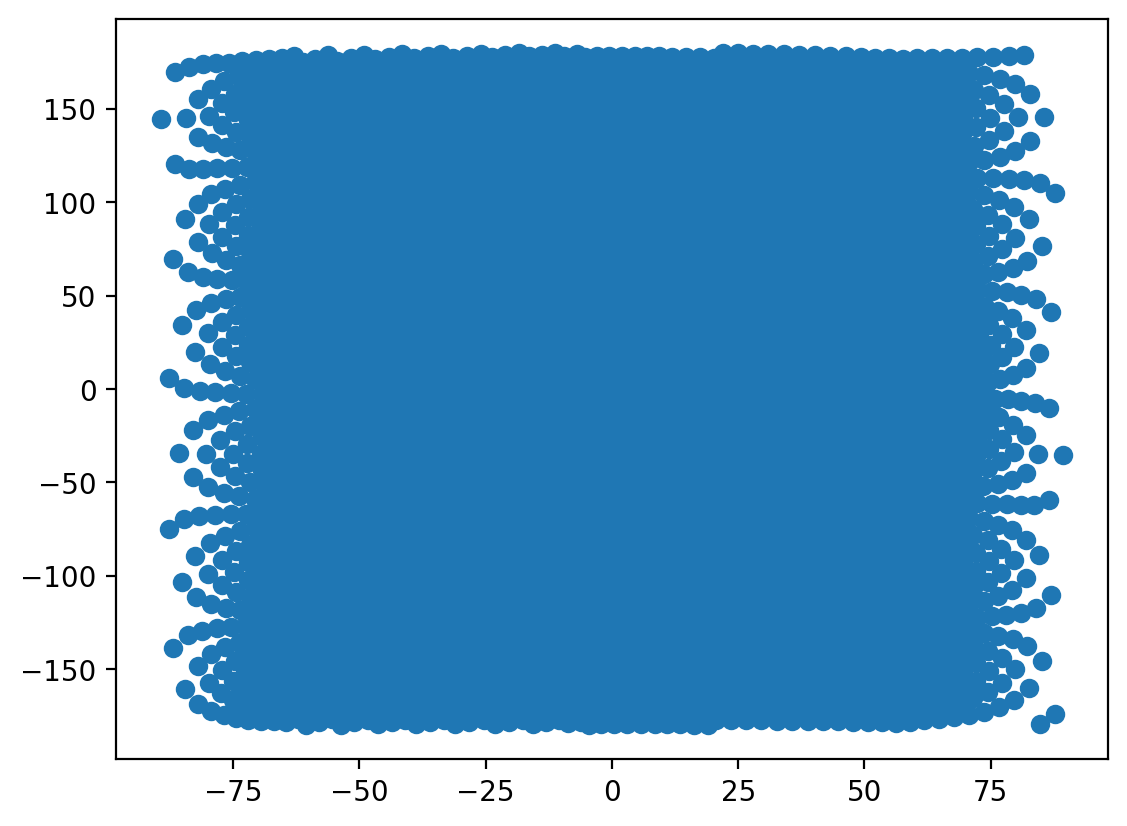

In [147]:
plt.scatter(hcoords[:,0],hcoords[:,1])

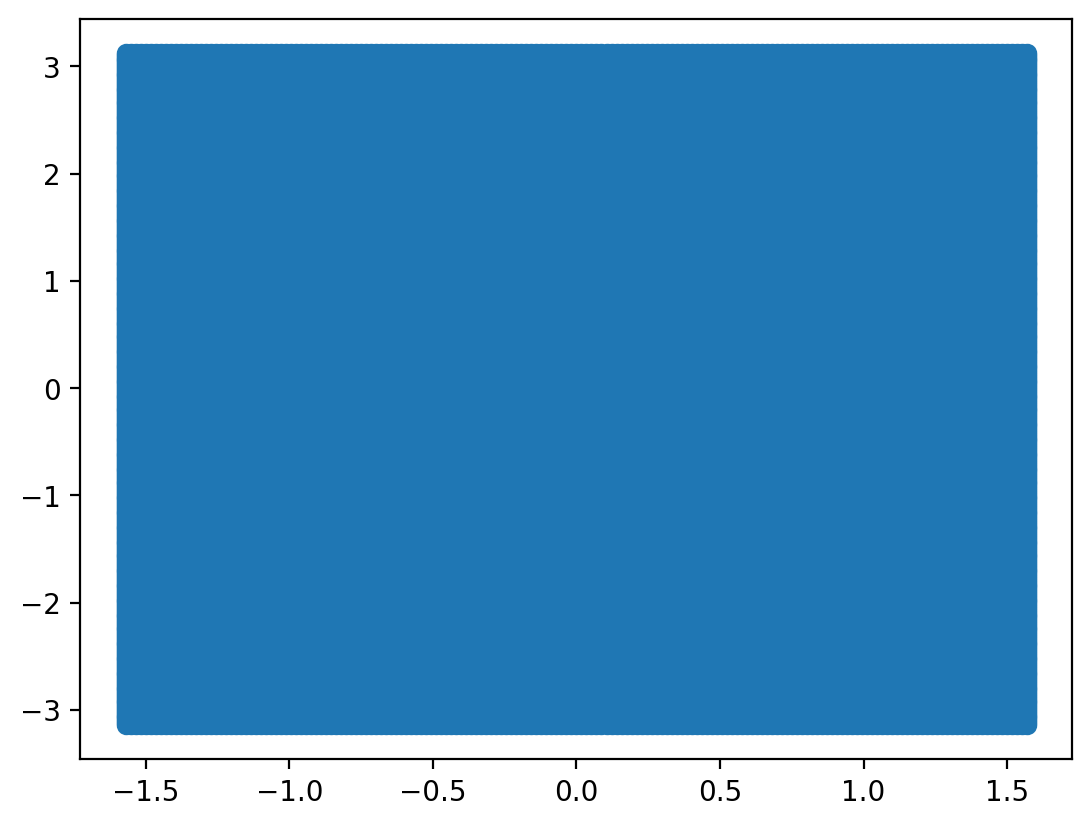

In [104]:
plt.scatter(ecoords_sp[:,0],ecoords_sp[:,1])

In [148]:
eadjmat, hadjmat

(<65160x65160 sparse matrix of type '<class 'numpy.float64'>'
 	with 586440 stored elements in COOrdinate format>,
 <5882x5882 sparse matrix of type '<class 'numpy.float64'>'
 	with 41174 stored elements in COOrdinate format>)

In [149]:
from sklearn.preprocessing import normalize
eadjmat_norm = normalize(eadjmat, norm="l1", axis=1)
eadjmat_norm.data = 1.0 - eadjmat_norm.data
eadjmat_norm

<65160x65160 sparse matrix of type '<class 'numpy.float64'>'
	with 586440 stored elements in Compressed Sparse Row format>

In [150]:
eadjmat_norm[0, :].data

array([1.        , 0.94999391, 0.89999232, 0.84999766, 0.8000151 ,
       0.8000156 , 0.84999816, 0.89999282, 0.94999442])

In [151]:
hadjmat_norm = normalize(hadjmat, norm="l1", axis=1)
hadjmat_norm.data = 1.0 - hadjmat_norm.data
hadjmat_norm

<5882x5882 sparse matrix of type '<class 'numpy.float64'>'
	with 41174 stored elements in Compressed Sparse Row format>

In [152]:
hadjmat.col

array([   0,    4,    3, ..., 5875, 5879, 5722], dtype=int32)

In [153]:
hadjmat_norm[0, :].data

array([1.        , 0.82895326, 0.82895326, 0.83609178, 0.84193919,
       0.83203125, 0.83203125])

In [154]:
# includes "self"
NUM_H3_TO_ERA_NEIGHBORS = 3
NUM_ERA_TO_H3_NEIGHBORS = 12

In [155]:
# compute mappings
# H3 -> ERA aka the "decoder"
h3_to_era_adjmat = hneigh.kneighbors_graph(
    ecoords_sp,
    n_neighbors=NUM_H3_TO_ERA_NEIGHBORS,
    mode="distance",
).tocoo()

# ERA -> H3 aka the "encoder"
era_to_h3_adjmat = eneigh.kneighbors_graph(
    hcoords_sp,
    n_neighbors=NUM_ERA_TO_H3_NEIGHBORS,
    mode="distance",
).tocoo()

In [156]:
h3_to_era_adjmat

<65160x5882 sparse matrix of type '<class 'numpy.float64'>'
	with 195480 stored elements in COOrdinate format>

In [157]:
hadjmat.max(),hadjmat.min()

(0.06641611377482927, 0.0)

In [158]:
h3_to_era_adjmat.max(),h3_to_era_adjmat.min()

(0.05389396131284059, 0.0)

In [159]:
np.unravel_index(h3_to_era_adjmat.argmax(),h3_to_era_adjmat.shape)

(31101, 3083)

In [160]:
h3_to_era_adjmat.data[49327-24:49327+5]

array([0.01389967, 0.02614526, 0.03974846, 0.04728005, 0.03340322,
       0.01992638, 0.008907  , 0.01275266, 0.02543491, 0.03914336,
       0.04101556, 0.03118841, 0.02567173, 0.02722632, 0.03492002,
       0.04644935, 0.04298807, 0.04392188, 0.03969118, 0.0390185 ,
       0.04344008, 0.04327514, 0.03154552, 0.02302432, 0.02185841,
       0.02895059, 0.04013881, 0.03769052, 0.02352629])

In [161]:
h3_to_era_adjmat.col[49327-12:49327+5]

array([882, 882, 882, 882, 882, 882, 883, 883, 883, 883, 883, 883, 883,
       883, 883, 883, 883], dtype=int32)

In [162]:
hcoords_sp[h3_to_era_adjmat.col[49327-12:49327+5],:]

array([[0.62043161, 1.66316429],
       [0.62043161, 1.66316429],
       [0.62043161, 1.66316429],
       [0.62043161, 1.66316429],
       [0.62043161, 1.66316429],
       [0.62043161, 1.66316429],
       [0.61460276, 1.72136244],
       [0.61460276, 1.72136244],
       [0.61460276, 1.72136244],
       [0.61460276, 1.72136244],
       [0.61460276, 1.72136244],
       [0.61460276, 1.72136244],
       [0.61460276, 1.72136244],
       [0.61460276, 1.72136244],
       [0.61460276, 1.72136244],
       [0.61460276, 1.72136244],
       [0.61460276, 1.72136244]])

In [163]:
ecoords_sp[h3_to_era_adjmat.row[49327-12:49327+5],:]

array([[0.6457718 , 1.6580628 ],
       [0.6457718 , 1.6755161 ],
       [0.6457718 , 1.6929693 ],
       [0.6632251 , 1.6406095 ],
       [0.6632251 , 1.6580628 ],
       [0.6632251 , 1.6755161 ],
       [0.57595867, 1.7104226 ],
       [0.57595867, 1.727876  ],
       [0.57595867, 1.7453293 ],
       [0.5934119 , 1.6755161 ],
       [0.5934119 , 1.6929693 ],
       [0.5934119 , 1.7104226 ],
       [0.5934119 , 1.727876  ],
       [0.5934119 , 1.7453293 ],
       [0.5934119 , 1.7627826 ],
       [0.61086524, 1.6755161 ],
       [0.61086524, 1.6929693 ]], dtype=float32)

In [164]:
h3_to_era_adjmat.row[49327-12:49327+5]

array([45995, 45996, 45997, 46354, 46355, 46356, 44558, 44559, 44560,
       44916, 44917, 44918, 44919, 44920, 44921, 45276, 45277],
      dtype=int32)

In [165]:
era_to_h3_adjmat.max(),era_to_h3_adjmat.min()

(0.03648317456381662, 0.0)

In [166]:
h3_to_era_adjmat_norm = normalize(h3_to_era_adjmat, norm="l1", axis=1)
h3_to_era_adjmat_norm.data = 1.0 - h3_to_era_adjmat_norm.data
h3_to_era_adjmat_norm

<65160x5882 sparse matrix of type '<class 'numpy.float64'>'
	with 195480 stored elements in Compressed Sparse Row format>

In [167]:
era_to_h3_adjmat

<5882x65160 sparse matrix of type '<class 'numpy.float64'>'
	with 70584 stored elements in COOrdinate format>

In [168]:
era_to_h3_adjmat.data[:10]

array([0.00445776, 0.00437873, 0.00431455, 0.00426589, 0.00423331,
       0.00421719, 0.00421773, 0.00423492, 0.00426855, 0.00431823])

In [169]:
era_to_h3_adjmat_norm = normalize(era_to_h3_adjmat, norm="l1", axis=1)
era_to_h3_adjmat_norm.data = 1.0 - era_to_h3_adjmat_norm.data
era_to_h3_adjmat_norm

<5882x65160 sparse matrix of type '<class 'numpy.float64'>'
	with 70584 stored elements in Compressed Sparse Row format>

In [170]:
tmp = era_to_h3_adjmat_norm[:10].toarray()
nz_idx = np.where(tmp != 0.)
tmp[tmp != 0].shape

(120,)

In [171]:
nz_idx

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9]),
 array([61054, 61055, 61056, 61057, 61058, 61059, 61060, 61061, 61062,
        61417, 61418, 61419, 62126, 62127, 62128, 62129, 62130, 62131,
        62132, 62133, 62134, 62135, 62136, 62137, 60708, 60709, 60710,
        60711, 60712, 60713, 60714, 60715, 60716, 61071, 61072, 61073,
        61785, 61786, 61787, 61788, 61789, 61790, 61791, 61792, 61793,
        61794, 61795, 61796, 60326, 60327, 60328, 60329, 60330, 60331,
        60332, 60333, 60688, 60689, 60690, 60691, 61041, 61042, 61043,
        61044, 61399, 61400, 61401, 61402, 61403, 61404, 61405, 61406,
        59979, 59980, 

In [172]:
tmp[9, [1800, 1801,1802, 1803, 1804, 1805, 1806, 2155, 2156, 2157, 2158, 2159]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [173]:
tmp = hadjmat_norm[:10, :].toarray()
nz_idx = np.where(tmp != 0.)
nz_idx

(array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6,
        6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9,
        9, 9, 9, 9]),
 array([ 0,  1,  2,  3,  4,  5,  6,  0,  1,  3,  5,  9, 13, 25,  0,  2,  3,
         6, 18, 19, 43,  0,  1,  2,  3, 19, 25, 27,  0,  4,  5,  6, 29, 31,
        37,  0,  1,  4,  5, 13, 37, 38,  0,  2,  4,  6, 31, 43, 47,  7,  8,
         9, 10, 11, 12, 13,  7,  8, 10, 12, 82, 88, 90,  1,  7,  9, 10, 13,
        25, 26]))

In [174]:
tmp[9, [7,  8,  9 , 10, 11, 12, 13]]

array([0.83547212, 0.        , 1.        , 0.82864954, 0.        ,
       0.        , 0.83979409])

In [175]:
graphs = HeteroData(
    {
        # we should swap rows and cols here. It does not matter too much since the
        # adjacency matrix is symmetric but better be consistent
        ("h", "to", "h"): {
            "edge_index": torch.from_numpy(np.stack([hadjmat.col, hadjmat.row], axis=0).astype(np.int64)),
            "edge_attr": torch.from_numpy(np.expand_dims(hadjmat.data, axis=-1).astype(np.float32)),
            "hcoords_rad": torch.from_numpy(hcoords_sp.astype(np.float32)),
            "hinfo": "H3",
        },

        # and again here
        ("era", "to", "era"): {
            "edge_index": torch.from_numpy(np.stack([eadjmat.col, eadjmat.row], axis=0).astype(np.int64)),
            "edge_attr": torch.from_numpy(np.expand_dims(eadjmat.data, axis=-1).astype(np.float32)),
            "ecoords_rad": torch.from_numpy(ecoords_sp.astype(np.float32)),
        },

        # be careful, we need to swap rows and cols here
        ("h", "to", "era"): {
            "edge_index": torch.from_numpy(np.stack([h3_to_era_adjmat.col, h3_to_era_adjmat.row], axis=0).astype(np.int64)),
            "edge_attr": torch.from_numpy(np.expand_dims(h3_to_era_adjmat.data, axis=-1).astype(np.float32)),
            "hcoords_rad": torch.from_numpy(hcoords_sp.astype(np.float32)),
            "ecoords_rad": torch.from_numpy(ecoords_sp.astype(np.float32)),
            "hinfo": "H3",
        },

        ("era", "to", "h"): {
            "edge_index": torch.from_numpy(np.stack([era_to_h3_adjmat.col, era_to_h3_adjmat.row], axis=0).astype(np.int64)),
            "edge_attr": torch.from_numpy(np.expand_dims(era_to_h3_adjmat.data, axis=-1).astype(np.float32)),
            "hcoords_rad": torch.from_numpy(hcoords_sp.astype(np.float32)),
            "ecoords_rad": torch.from_numpy(ecoords_sp.astype(np.float32)),
            "hinfo": "H3",
        },
    }
)

In [176]:
graphs_normed = HeteroData(
    {
        # we should swap rows and cols here. It does not matter too much since the
        # adjacency matrix is symmetric but better be consistent
        ("h", "to", "h"): {
            "edge_index": torch.from_numpy(np.stack([hadjmat.col, hadjmat.row], axis=0).astype(np.int64)),
            "edge_attr": torch.from_numpy(np.expand_dims(hadjmat_norm.data, axis=-1).astype(np.float32)),
            "hcoords_rad": torch.from_numpy(hcoords_sp.astype(np.float32)),
            "hinfo": "H3",
        },

        # and again here
        ("era", "to", "era"): {
            "edge_index": torch.from_numpy(np.stack([eadjmat.col, eadjmat.row], axis=0).astype(np.int64)),
            "edge_attr": torch.from_numpy(np.expand_dims(eadjmat_norm.data, axis=-1).astype(np.float32)),
            "ecoords_rad": torch.from_numpy(ecoords_sp.astype(np.float32)),
        },

        # be careful, we need to swap rows and cols here
        ("h", "to", "era"): {
            "edge_index": torch.from_numpy(np.stack([h3_to_era_adjmat.col, h3_to_era_adjmat.row], axis=0).astype(np.int64)),
            "edge_attr": torch.from_numpy(np.expand_dims(h3_to_era_adjmat_norm.data, axis=-1).astype(np.float32)),
            "hcoords_rad": torch.from_numpy(hcoords_sp.astype(np.float32)),
            "ecoords_rad": torch.from_numpy(ecoords_sp.astype(np.float32)),
            "hinfo": "H3",
        },

        ("era", "to", "h"): {
            "edge_index": torch.from_numpy(np.stack([era_to_h3_adjmat.col, era_to_h3_adjmat.row], axis=0).astype(np.int64)),
            "edge_attr": torch.from_numpy(np.expand_dims(era_to_h3_adjmat_norm.data, axis=-1).astype(np.float32)),
            "hcoords_rad": torch.from_numpy(hcoords_sp.astype(np.float32)),
            "ecoords_rad": torch.from_numpy(ecoords_sp.astype(np.float32)),
            "hinfo": "H3",
        },
    }
)

# Add directionality attribute

In [177]:
#
hhedge_dirs = []
for n in range(graphs_normed[("h", "to", "h")]['edge_index'].shape[1]):
    i,j = graphs_normed[("h", "to", "h")]['edge_index'][:,n]
    ic = graphs_normed[("h", "to", "h")]['hcoords_rad'][i,:]
    jc = graphs_normed[("h", "to", "h")]['hcoords_rad'][j,:]
    hhedge_dirs.append(jc - ic)
hhedge_dirs = torch.from_numpy(np.stack(hhedge_dirs).astype(np.float32))
hhedge_attr = torch.concat([graphs_normed[("h", "to", "h")]['edge_attr'],hhedge_dirs],axis=-1)

In [178]:
#
ehedge_dirs = []
for n in range(graphs_normed[("era", "to", "h")]['edge_index'].shape[1]):
    i,j = graphs_normed[("era", "to", "h")]['edge_index'][:,n]
    ic = graphs_normed[("era", "to", "h")]['ecoords_rad'][i,:]
    jc = graphs_normed[("era", "to", "h")]['hcoords_rad'][j,:]
    ehedge_dirs.append(jc - ic)
ehedge_dirs = torch.from_numpy(np.stack(ehedge_dirs).astype(np.float32))
ehedge_attr = torch.concat([graphs_normed[("era", "to", "h")]['edge_attr'],ehedge_dirs],axis=-1)

#
heedge_dirs = []
for n in range(graphs_normed[("h", "to", "era")]['edge_index'].shape[1]):
    i,j = graphs_normed[("h", "to", "era")]['edge_index'][:,n]
    ic = graphs_normed[("h", "to", "era")]['hcoords_rad'][i,:]
    jc = graphs_normed[("h", "to", "era")]['ecoords_rad'][j,:]
    heedge_dirs.append(jc - ic)
heedge_dirs = torch.from_numpy(np.stack(heedge_dirs).astype(np.float32))
heedge_attr = torch.concat([graphs_normed[("h", "to", "era")]['edge_attr'],heedge_dirs],axis=-1)

graphs_normed[("h", "to", "era")]['edge_attr'] = heedge_attr
graphs_normed[("h", "to", "h")]['edge_attr'] = hhedge_attr
graphs_normed[("era", "to", "h")]['edge_attr'] = ehedge_attr

graphs[("h", "to", "era")]['edge_attr'] = heedge_attr
graphs[("h", "to", "h")]['edge_attr'] = hhedge_attr
graphs[("era", "to", "h")]['edge_attr'] = ehedge_attr


print(graphs_normed[("era", "to", "h")]['edge_attr'].shape)

torch.Size([70584, 3])


In [179]:
print(graphs[("h", "to", "h")]['edge_attr'].shape)

torch.Size([41174, 3])


In [180]:
output_dir = "/ec/res4/hpcperm/pamc/gnn/"
torch.save(graphs, os.path.join(output_dir, "graph_mappings.pt"))

output_dir = "/ec/res4/hpcperm/pamc/gnn/"
torch.save(graphs_normed, os.path.join(output_dir, "graph_mappings_normed_edge_attrs.pt"))

In [65]:
!ls -l $HPCPERM/gnn

total 83112
-rw-r--r-- 1 pamc rd 21688123 Feb 12 20:37 graph_mappings_normed_edge_attrs_o32.pt
-rw-r--r-- 1 pamc rd 22040699 Feb 13 22:05 graph_mappings_normed_edge_attrs.pt
-rw-r--r-- 1 pamc rd 19326587 Feb 12 20:37 graph_mappings_o32.pt
-rw-r--r-- 1 pamc rd 22040699 Feb 13 22:05 graph_mappings.pt
